In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def plot(x, y, x_label=None, y_label=None, title=None, name_save_file=None, points=None):
    if title:
        plt.title(title)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if points:
        for point in points:
            plt.scatter(*point, c="green")
    plt.plot(x, y)
    if name_save_file:
        plt.savefig(name_save_file)
    plt.grid()
    plt.show()

def calc_mutual_inductance(coil_1, coil_2, d, po=0, fi=0):
    mu0 = 1.26 * 10 ** (-6)
    mutual_inductance = np.ones((len(coil_1), len(coil_2)))
    N = 180
    K = 180
    df1 = 2 * np.pi / N
    df2 = 2 * np.pi / K
    for ri in range(len(coil_1)):
        for rj in range(len(coil_2)):
            M = 0
            for n in range(N):
                for k in range(K):
                    xk_xn = po + coil_1[ri] * np.cos(df2 * k) * np.cos(fi) - coil_2[rj] * np.cos(df1 * n)
                    yk_yn = coil_1[ri] * np.sin(df2 * k) * np.cos(fi) - coil_2[rj] * np.sin(df1 * n)
                    zk_zn = d + coil_1[ri] * np.cos(df2 * k) * np.sin(fi)
                    r12 = (xk_xn ** 2 + yk_yn ** 2 + zk_zn ** 2) ** 0.5
                    M += (np.cos(df2 * k - df1 * n) * df1 * df2) / r12
            M *= mu0 * coil_1[ri] * coil_2[rj] / (4 * np.pi)
            mutual_inductance[ri][rj] = M
    return np.sum(mutual_inductance)

def calc_self_inductance(coil, thin):
    mu0 = 4 * np.pi * 10 ** (-7)
    L = np.sum(mu0 * coil * (np.log(8 * coil / thin) - 7 / 4 + (thin ** 2) / (8 * coil ** 2) * (np.log(8 * coil / thin) + 1 / 3)))
    mu0 = 1.26 * 10 ** (-6)
    mutual_inductance = np.ones((len(coil), len(coil)))
    N = 180
    K = 180
    df1 = 2 * np.pi / N
    df2 = 2 * np.pi / K
    d = 0
    po = 0
    fi = 0
    for ri in range(len(coil)):
        for rj in range(len(coil)):
            M = 0
            if ri != rj:
                for n in range(N):
                    for k in range(K):
                        xk_xn = po + coil[ri] * np.cos(df2 * k) * np.cos(fi) - coil[rj] * np.cos(df1 * n)
                        yk_yn = coil[ri] * np.sin(df2 * k) * np.cos(fi) - coil[rj] * np.sin(df1 * n)
                        zk_zn = d + coil[ri] * np.cos(df2 * k) * np.sin(fi)
                        r12 = (xk_xn ** 2 + yk_yn ** 2 + zk_zn ** 2) ** 0.5
                        M += (np.cos(df2 * k - df1 * n) * df1 * df2) / r12
                M *= mu0 * coil[ri] * coil[rj] / (4 * np.pi)
            mutual_inductance[ri][rj] = M
    M = np.sum(mutual_inductance)
    L += M
    return L

def calc_coupling_coef(L1, L2, M):
    return M / (np.sqrt(L1 * L2))

In [12]:
# размеры витков для первой катушки индуктивности в метрах
coil_1 = np.linspace(0.028, 0.07, 4)

# размеры витков для второй катушки индуктивности в метрах
coils_2 = np.linspace(0.03, 0.09, 4) + np.zeros((100, 4))
coils_2.T[2] = np.linspace(coils_2[0][1]+1e-6, coils_2[0][3]-1e-6, 100)

# расстояние между катушками в метрах
d = 0.005

In [13]:
# расчёт взаимной индуктивности между катушками
M = np.array([])
for coil in coils_2:
    M = np.append(M, calc_mutual_inductance(coil, coil_1, d))

# расчёт собственной индуктивности катушек
L1 = calc_self_inductance(coil_1, thin=0.001)
L2 = np.array([])

for coil in coils_2:
    L2 = np.append(L2, calc_self_inductance(coil, thin=0.001))

# расчёт коэффициента связи двух катушек
k = calc_coupling_coef(L1, L2, M)

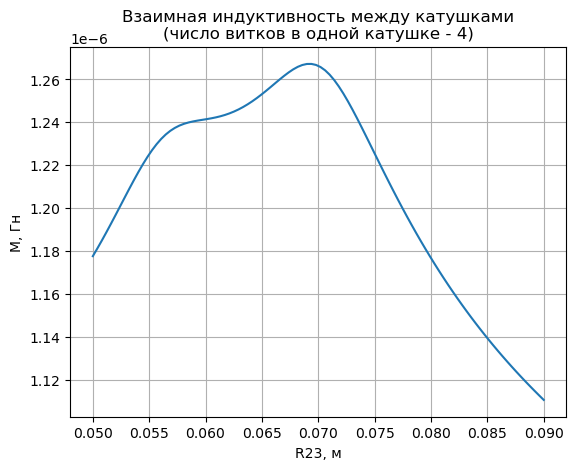

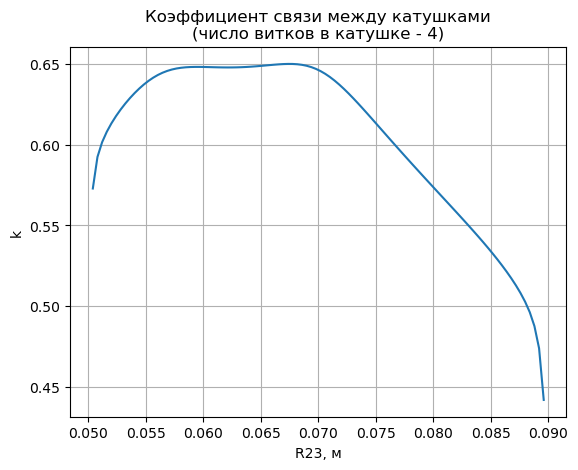

In [15]:
plot(coils_2.T[2], M, title="Взаимная индуктивность между катушками\n(число витков в одной катушке - 4)",
    x_label="R23, м", y_label="M, Гн")

plot(coils_2.T[2][1:-1], k[1:-1], title="Коэффициент связи между катушками\n(число витков в катушке - 4)",
    x_label="R23, м", y_label="k")

## Применение steepest hill climbing algorithm для оптимизации формы катушки ##

In [23]:
# steepest hill climbing algorithm для поиска максимума функции
def mutation(start, finish, c, r=0.005):
    c[2] = np.random.uniform(low=start if c[2] - r < start else c[2] - r,
                             high=finish if c[2] + r > finish else c[2] + r)
    return c


def fitness_func(coil_1, coil_2, d):
    L1 = calc_self_inductance(coil_1, thin=0.001)
    L2 = calc_self_inductance(coil_2, thin=0.001)
    M = calc_mutual_inductance(coil_1, coil_2, d)
    return M / np.sqrt(L1 * L2)
    

good_mutation = []
bad_mutation = []
all_mutation = []

iteration = 50
thin = 0.001

c2 = np.linspace(0.03, 0.09, 4)
c2[2] = np.random.uniform(low=c2[1]+thin/2, high=c2[3])


for i in range(iteration):
    fit_k = fitness_func(coil_1, c2, d)
    c2_q = mutation(c2[1] + thin / 2, c2[3], c2)
    fit_kq = fitness_func(coil_1, c2_q, d)
    if fit_kq >= fit_k:
        good_mutation.append((c2_q[2], fit_kq))
        c2 = c2_q
        fit_k = fit_kq
    else:
        bad_mutation.append((c2[2], fit_kq))
    all_mutation.append((c2[2], fit_kq))

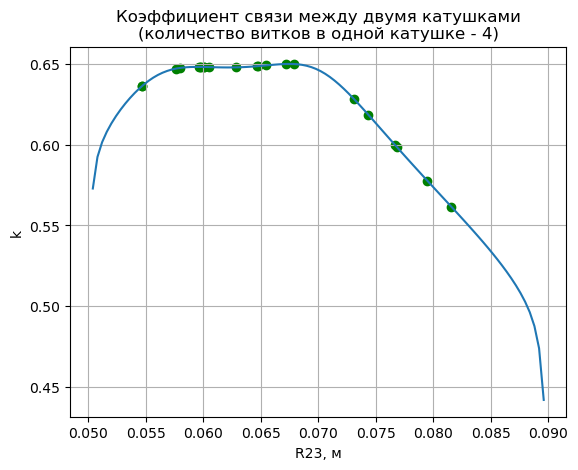

kmax = 0.5810390365042998; R2max = 0.08239468474737714 м
Количество полезных мутаций: 22
Количество вредных мутаций: 28
Всего мутаций: 50


In [24]:
plot(coils_2.T[2][1:-1], k[1:-1], x_label="R23, м", y_label="k",
     title="Коэффициент связи между двумя катушками\n(количество витков в одной катушке - 4)", points=good_mutation)

print(f"kmax = {fit_k}; R2max = {c2[2]} м")
print(f"Количество полезных мутаций: {len(good_mutation)}")
print(f"Количество вредных мутаций: {len(bad_mutation)}")
print(f"Всего мутаций: {len(all_mutation)}")